# Table of Contents
- [Project Definition](#Project-Definition)
  - [Project Overview](#Project-Overview)
  - [Problem Statement](#Problem-Statement)
  - [Metrics](#Metrics)
- [Analysis](#Analysis)
- [Methodology](#Methodology)
  - [Data Preprocessing](#Data-Preprocessing)
  - [Implementation](#Implementation)
  - [Refinement](#Refinement)
- [Conclusion](#Conclusion)
- [Future Work](#Future-Work)
- [Guides](#Guides)
- [Notes](#Notes)

# Project Definition

### Project Overview

Bullying has evolved to cyberbullying through the medium of the Internet and online social networks, and with the power of the Internet, online bullies can be illusive and more direct. According to [i-SAFE]( https://auth.isafe.org/outreach/media/media_cyber_bullying
), 42% of kids have been bullied while online, and 58% have not told their parents or an adult about something mean or hurtful that happened to them online. With machine learning, programmers are able to create solutions that can detect cyberbullying to a certain degree.

In this project, I created a Python Flask web application that classifies a tweet (including hashtags) between good or bad. The model is trained on a dataset of classified Tweets from [Dataturks through Kaggle](https://www.kaggle.com/dataturks/dataset-for-detection-of-cybertrolls) and utilizes the combination of Bag of Words and TF-IDF to focus on the frequency of individual words. 

### Problem Statement

The goal is to create a web application that detects cyberbullying

The steps involved are the following:
1. Download and preprocess the labeled JSON Tweet data
2. Train a classifier that can determine if a Tweet is good or bad
3. Deploy application
4. User inputs tweet
5. Application displays classification

The application can help adults classify ambiguous tweets that may carry different meanings.

### Metrics

The confusion matrix is a specific table layout that allows visualization of the performance of an algorithm. In this case, it will display the count of true negatives, false negatives, true positives, and false positives from the predictions of our model compared to the true values.

<img src="imgs/confmatrix.png" alt="Confusion Matrix" style="width: 700px;"/>

Accuracy is one metric for evaluating classification models. It is the ratio of number of correct predictions to the total number of input samples.

${\displaystyle \mathrm {accuracy} ={\frac {\mathrm {TP} +\mathrm {TN} }{\mathrm {P} +\mathrm {N} }}={\frac {\mathrm {TP} +\mathrm {TN} }{\mathrm {TP} +\mathrm {TN} +\mathrm {FP} +\mathrm {FN} }}}$

# Analysis

Some additional analysis has been done on Kaggle:
<br>https://www.kaggle.com/kevinlwebb/cybertrolls-exploration-and-ml

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sqlalchemy import create_engine
from joblib import dump, load

import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kevinwebb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kevinwebb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kevinwebb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [3]:
# load data
engine = create_engine('sqlite:///data/TweetSentiment.db')
df = pd.read_sql_table('tweets', engine)

# load model
model = load("models/classifier.pkl")

In [4]:
df.head()

,cleaned_tweet,label
0,Get fucking real dude.,1
1,She is as dirty as they come and that crook ...,1
2,why did you fuck it up. I could do it all day...,1
3,Dude they dont finish enclosing the fucking s...,1
4,WTF are you talking about Men? No men thats n...,1


In [5]:
df.groupby("label").count()

,cleaned_tweet
label,
0,12179
1,7822


In [6]:
bad_per = (len(df[df.label == '1']) / len(df)) * 100
print("Percent of bad tweets: {}".format(bad_per))

good_per = (len(df[df.label == '0']) / len(df)) * 100
print("Percent of good tweets: {}".format(good_per))

Percent of bad tweets: 39.10804459777012
Percent of good tweets: 60.89195540222989


A good distribution between the two labels. An imbalanced classification problem involves predicting a label where the distribution of labels in the training dataset is not relatively equal. The original dataset was switched to a more distributed dataset, but if I continued with the original dataset, one approach to addressing the imbalanced dataset was to oversample the minority class.

In [7]:
sw = stopwords.words("english")
text = df.cleaned_tweet.str.cat(sep=' ')
text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
str_list = text.split(" ")
s = pd.Series(str_list)
s = s[s != ""]
s = s[~s.isin(sw)]

top_10 = s.value_counts()[:10]
word_counts = s.value_counts()[:10].tolist()
word_names = s.value_counts()[:10].index.tolist()

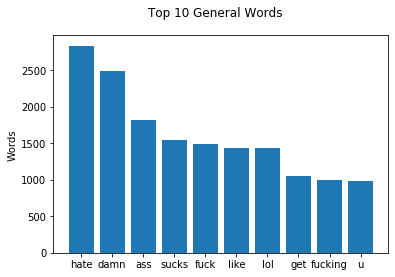

In [8]:
x = word_names
y = word_counts
plt.bar(x, y)
plt.ylabel('Frequency')
plt.ylabel('Words')
plt.suptitle('Top 10 General Words')
plt.show()

In [9]:
text = df[df.label == '1'].cleaned_tweet.str.cat(sep=' ')
text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
str_list = text.split(" ")
s = pd.Series(str_list)
s = s[s != ""]
s = s[~s.isin(sw)]

bad_top_10 = s.value_counts()[:10]
bad_word_counts = s.value_counts()[:10].tolist()
bad_word_names = s.value_counts()[:10].index.tolist()

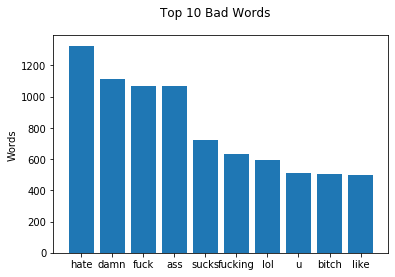

In [10]:
x = bad_word_names
y = bad_word_counts
plt.bar(x, y)
plt.ylabel('Frequency')
plt.ylabel('Words')
plt.suptitle('Top 10 Bad Words')
plt.show()

In [11]:
text = df[df.label == '0'].cleaned_tweet.str.cat(sep=' ')
text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
str_list = text.split(" ")
s = pd.Series(str_list)
s = s[s != ""]
s = s[~s.isin(sw)]

good_top_10 = s.value_counts()[:10]
good_word_counts = s.value_counts()[:10].tolist()
good_word_names = s.value_counts()[:10].index.tolist()

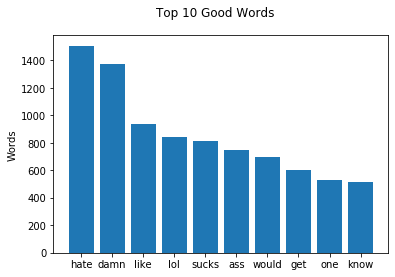

In [12]:
x = good_word_names
y = good_word_counts
plt.bar(x, y)
plt.ylabel('Frequency')
plt.ylabel('Words')
plt.suptitle('Top 10 Good Words')
plt.show()

Despite having a balanced dataset in terms of the labels, traditionally bad words like 'hate' are still found in the labelled 'good' half of the dataset. Since the model is mainly looking at the frequency of words, the model will have a hard time classifying without understanding context.

In [13]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from '/Users/kevinwebb/Desktop/env/ds/lib/python3.7/site-packages/matplotlib/pyplot.py'>

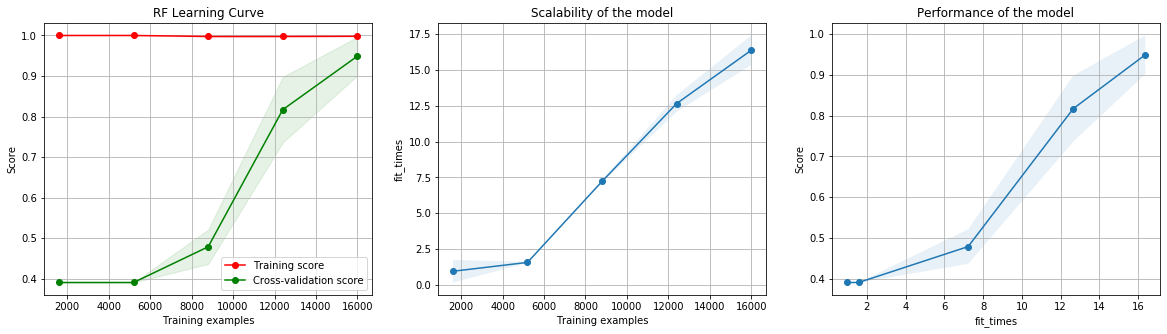

In [14]:
X = df.cleaned_tweet.values
Y = df.label.values
plot_learning_curve(model, "RF Learning Curve", X, Y)

Takeaways
1. Training score (red line) is at its maximum regardless of training examples
  - This shows severe overfitting
2. Cross-validation score (green line) increases over time
3. Small gap between cross-validation score and training score indicates low variance scenario
  - Good complexity of the model or large amount of data

In [15]:
query = "I hate you"

if model.predict([query])[0] == '0':
    print("The Tweet '{}' is a good tweet".format(query))
else:
    print("The Tweet '{}' is a bad tweet".format(query))

The Tweet 'I hate you' is a good tweet


# Methodology

### Data Preprocessing

The ETL (Extraxct, Transform, Load) process done in ` process_data.py` consists of the following steps: 
1. The data is read from a json file
2. The tweets and labels are separated into a DataFrame
3. The  DataFrame is stored as a table titled “tweets” in a SQLalchemy database (.db file)

There are also some preprocessing steps in ` train_classifier.py` which are done as part of the tokenization process: 
1. The input tweets are individually separated into a list of words
2. Stop words, commonly used words (such as “the”, “a”, “an”, “in”), are removed from the word list
3. Characters outside of a-z, A-Z, and 0-9 are removed

### Implementation

The implementation process can be split into two main stages: 
1. The classifier training stage 
2. The application development stage 

The classifier training stage follows these steps in `train_classifier.py`: 
1. Load table ‘tweets’ from SQL database 
2. Separate the labels from the outputs and assign them to their individual variables 
3. Split data between train and test
4. Train with the designated training data
  - The model pipeline includes Bag of Words, TF-IDF, and Random Forest
5. Log the accuracy and confusion matrix
6. Save the trained model

The application development stage follows these steps in `run.py`: 
1. Load the saved model and ‘tweets’ table from the SQL database 
2. Create graphs visualizing data analysis 
3. Pass data through to html file
4. Run the Flask application with the command `python run.py`

### Refinement

The combination of Bag of Words, TF-IDF, and Random Forest yielded a good accuracy score of 91%. As seen below, the confusion matrix demonstrates a good distribution between true positives and true negatives.

```
Confusion Matrix:
 [[2189  258]
 [  80 1474]]
Accuracy: 0.91552111972007
```

GridSearchCV, an exhaustive search over specified parameter values for an estimator, was implemented with the following parameters

```python
parameters = {
   'tfidf__smooth_idf':[True, False],
    'vect__ngram_range': ((1, 1), (1, 2)),
    'clf__n_estimators': [50, 100, 200],

}

cv = GridSearchCV(pipeline, param_grid=parameters, cv = 3)
```

The GridSearchCV yielded an accuracy score of 95% and produced the following:

```
Best parameters: {'clf__n_estimators': 200, 'tfidf__smooth_idf': False, 'vect__ngram_range': (1, 1)}

Confusion Matrix:
 [[2380   82]
 [  93 1446]]
Accuracy: 0.956260934766
```

The GridSearchCV is not implemented in the current code due to the time that it consumes to train. The code is shared above for reference.

# Conclusion

The divide of data between good and bad is great, but after seeing that 'hate' and other bad words are shared between classified bad and good, the data is still skewed. The model was tested at the end of [Analysis](#Analysis) with a sentence with clear bad sentiment, but because of the skewed data (and other factors), the model predicted that the sentence has 'good' sentiment.

Also, the model was overfitting as shown at the end of [Analysis](#Analysis). This may be due to a lack of complexity in the dataset. Two solutions are to add more data with more complexity and to tune the model's parameters.

Below, you'll find different methods and solutions that may help in correctly classifying Tweets.

# Future Work

- Implement analysis on live Tweets
- Switch from classification to regression
- Switch and / or add new dataset
  - [sentiment140 dataset](https://www.kaggle.com/kazanova/sentiment140)
- Use more libraries and tools
  - textblob
- Utilize Hashtags, Emoticons, and Emojis
- Combat overfitting
  - Tune model parameters
    - Parameter: the number of features that are randomly chosen to grow each tree from the bootstrapped data
    - Parameter: 𝑘-fold cross-validation
    - nodesize - minimum size of terminal nodes
    - maxnodes - maximum number of terminal nodes
    - mtry - number of variables used to build each tree
- Correct imbalanced dataset
  - oversample
  - [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
- Diverge from Udacity HTML template

In [16]:
import os
from tweepy import Stream, OAuthHandler, API
from tweepy.streaming import StreamListener
import json
import pandas as pd
import csv
import re

In [17]:
#Twitter credentials for the app
consumer_key = os.environ['twitter_consumer_key']
consumer_secret = os.environ['twitter_consumer_secret']
access_key= os.environ['twitter_access_key']
access_secret = os.environ['twitter_access_secret']

In [18]:
#pass twitter credentials to tweepy
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = API(auth)

In [19]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [20]:
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [21]:
timeline = api.user_timeline(user_id="realDonaldTrump", count=200)

In [22]:
for what in timeline:
    print(what.text, "\n")

https://t.co/61KbAnpncb
Hey Google! Where's my shirt? 😁
#GCP #GoogleCloud @GCPcloud https://t.co/y8s4UhkT5m 

#ATTLIVE17 amazing things happen here https://t.co/21TovQK4Ub 

#ATTLIVE17 caught in the act https://t.co/VEcGwbbOoC 

#ATTLIVE17 morning views https://t.co/dcf6Q5N1wX 

@DTgolfstar @CauseWereGuys better goalie than I'll ever be. It should be Central's goalkeeper coach 👀 

RT @bayer04fussball: #Chicharito kommt von @ManUtd und unterschreibt bei der #Werkself bis 2018 || @CH14_ joins #Bayer04 until 2018! http:/… 

@destiny_belle getting there at 11 vs getting a decent parking spot. Your choice 😆 

@destiny_belle get there earlier 

RT @Lambdas1975: Congratulations to Delta Zeta Chapter (University of West Georgia) for earning the highest fraternity chapter GPA... http:… 

@Andy_Hartsfield you forgot #kevinislame gosh! 

@VivaDat_Stud how you should feel http://t.co/G5Z5GMpq4z 

@destiny_belle so... is this confirmation to do it? Or nah? 

@destiny_belle demand a year's worth of 

In [23]:
search = api.search(q="Trump", tweet_mode = 'extended', lang="en", rpp=5)

In [24]:
for tweet in search:
    print(tweet.full_text, "\n---------------------------\n")

RT @AndrewBatesNC: This is the President of the United States. For at least until next January. https://t.co/mAMjINFbdp https://t.co/IIKlmD… 
---------------------------

Just-the-flu mindset has many strains of mutation within the same theme: 

Always Trump
Freedom or die
If I get Corona I get Corona
CCP kills (US doesn't)
No vax (I hide behind the vaxxers)
Small Gov (let the States compete and kill each other for PPEs) 
Religious (science out!) 
---------------------------

RT @nytimes: President Trump was slow to absorb the scale of the risk the coronavirus pandemic posed to the U.S. and to act accordingly, ou… 
---------------------------

RT @realDonaldTrump: “Trump did a deal with Japan. A lot of our product goes to Japan, and we are booming in North Dakota.” Jim on C Span,… 
---------------------------

@Logic_Triumphs @joncoopertweets He does.  Probably cause Coronavirus is afraid of catching Trump!  😡😱 #COVFEFE19 
---------------------------

RT @JYSexton: Donald Trump wasn’t 

In [25]:
search = api.search(q="Alexandria Ocasio-Cortez", lang="en", tweet_mode = 'extended', include_rts=False, rpp=5)

In [26]:
for tweet in search:
    print(tweet.truncated)
    print(tweet.full_text)
    print("\n---------\n")

False
RT @AnnaApp91838450: Hard At Work:Alexandria Cortez Guest Judges ‘RuPaul‘s Drag Race‘ https://t.co/oc0KD8j4al  @BreitbartNews
 Why WriteThi…

---------

False
RT @TaxReformExpert: Alexandria Ocasio-Cortez is blaming 17 million Americans losing their jobs on capitalism.

How did capitalism cause th…

---------

False
AOC Made Every Queen’s Dream Come True — &amp; Spilled The Real Tea — On Drag Race #SmartNews  https://t.co/F2qJU3jLEr

---------

False
RT @TaxReformExpert: Alexandria Ocasio-Cortez is blaming 17 million Americans losing their jobs on capitalism.

How did capitalism cause th…

---------

False
RT @TaxReformExpert: Alexandria Ocasio-Cortez is blaming 17 million Americans losing their jobs on capitalism.

How did capitalism cause th…

---------

False
ATTEND Alexandria Ocasio-Cortez for Congress’s event, “Phone Bank Thursday to Tuesday  from 5PM -8PM (click to see details)” – sign up now!  https://t.co/e1HJtd53lZ

---------

False
RT @TaxReformExpert: Alexandria Ocasio

# Guides

https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf

https://towardsdatascience.com/tweepy-for-beginners-24baf21f2c25

# Notes

### [intellipaat](https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn)
There are some parameters of random forest that can be tuned for the model’s better performance.

- n_estimators: The more trees, the less likely the algorithm is to overfit. So try increasing this parameter. The lower this number, the closer the model is to a decision tree, with a restricted feature set.
- max_features: You should try reducing this number. This defines how many features each tree is randomly assigned. 
- max_depth: This parameter will reduce the complexity of the learned models, lowering over fitting risk. 
- min_samples_leaf: Try setting these values greater than one. This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each.